## Tutorial: how to import the data and visualise them

In [10]:
import numpy as np
import networkx as nx
import pandas as pd
import random
from tqdm import tqdm
#from tree import FamilyTree
from data_handler import ParticleDataset, OneSet

import ot
from hyperlib.embedding.sarkar import sarkar_embedding
import graphicle as gcl
from tree import FamilyTree

import matplotlib.pyplot as plt
from matplotlib.patches import Circle,ConnectionPatch

#helper functions for plots
from utils.visualisation import plot_geodesic, get_colors, hard_descendants
from utils.metrics import sqdist, distance_matrix, precision_and_recall, mAP, gencoordinates, compute_emd

from jupyterthemes import jtplot
jtplot.style(theme='oceans16')

## The dataset

The dataset is structured as a Pytorch dataset. The two inputs are the path for the data directory and the signal name (this depends on the physics event we are interested in and it is chosen once the data is generated).

The dataset spits each event as dictionary which contains a graphicle object and a hyperbolic coordinates array for each of the algorithm tree (AntiKt, CA and Kt) and for the MC truth.

In [2]:
dataset = ParticleDataset('data/multiple_shower')
#dataset = ParticleDataset('data/compare_tree/train_sig/')
event = dataset[1]

keys = [k for k in event.keys()]
print(f'Number of events: {len(dataset)}')
print(f'Data keys: {keys}')

Number of events: 999
Data keys: ['MC_graph', 'aKt_graph', 'aKt_hyp', 'CA_graph', 'CA_hyp', 'Kt_graph', 'Kt_hyp']


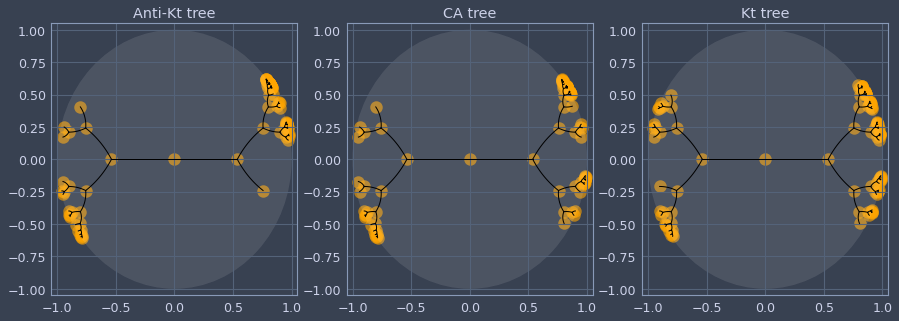

In [3]:
fig,ax = plt.subplots(1,3,figsize=(15,5))
ax = ax.flatten()

event = dataset[20]
keys = [k for k in event.keys()]
titles = ['Anti-Kt tree', 'CA tree', 'Kt tree',]
for k in range(1, 6, 2):
    i = k//2
    graph, hyp = event[keys[k]], event[keys[k+1]]
    #graph, hyp = event[keys[k]], event[keys[k+1]]
    
    G = nx.Graph()
    G.add_edges_from(graph.edges)
    nodes = np.array(G.nodes())
    mapping = {nodes[i]: i for i in range(len(nodes))}
    G = nx.relabel_nodes(G, mapping)
    nodes = np.array(G.nodes())
    for edge in G.edges:
        start = np.where(nodes == edge[0])[0][0]
        end = np.where(nodes == edge[1])[0][0]
        x0,y0 = hyp[start]
        x1,y1 = hyp[end]
        #ax.plot([x0,x1],[y0,y1],alpha=0.1,color='black')
        plot_geodesic(hyp[start],hyp[end],ax[i])

    ax[i].scatter(hyp[:,0], hyp[:,1], c='orange', s=150, alpha=0.6)
    
    disk = Circle((0,0),1,color='white',alpha=0.1)#fill=False)
    ax[i].add_patch(disk)
    ax[i].set_xlim(-1.05,1.05)
    ax[i].set_ylim(-1.05,1.05)
    ax[i].set_title(titles[i])

plt.show()
#plt.savefig('example.png')

## Testing Sarkar algorithm

In [57]:
#%run data_handler.py
#%run tree.py
dataset = ParticleDataset('data/newtest/')
event = dataset[0]
graph = event['MC_graph']
tree = FamilyTree(graph)
g = tree.history(R=.4, p=-1, pt_cut=15, eta_cut=2.5, recluster=True)

number of jets: 2
pt: 255.77198255832866
pt: 204.5814336789674


In [54]:
from hyperlib.embedding.sarkar import sarkar_embedding

#G = nx.balanced_tree(2,5)
#graph = event['Kt_graph']
G = nx.Graph()
#G.add_edges_from(akt.edges[1:])
G.add_edges_from(g.edges)
nodes = np.array(G.nodes())
mapping = {nodes[i]: i for i in range(len(nodes))}
G = nx.relabel_nodes(G, mapping)
#G = nx.balanced_tree(3,4)
embed = sarkar_embedding(tree=G, root=mapping[-1], tau=0.55, weighted=False)#, tau=tau)
#plot_embedding(T, emb, labels=labels)
hyp = np.array(list(map(float, embed))).reshape(-1,2)
print(f'mAP of embedding: {mAP(g, hyp)}')

mAP of embedding: 1.0


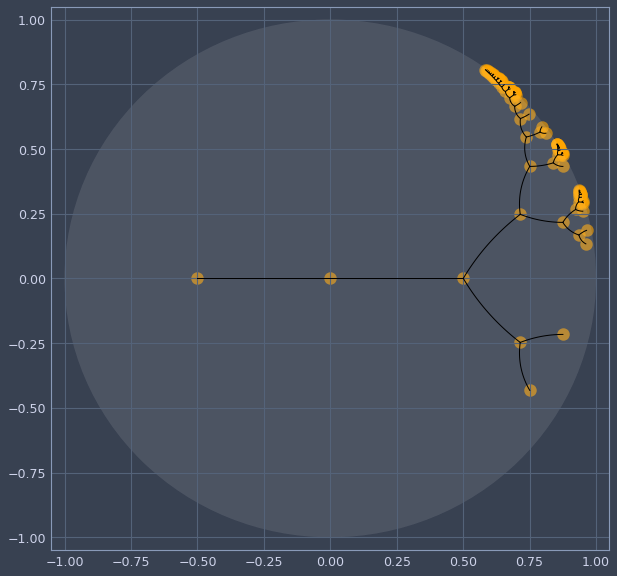

In [55]:
fig,ax = plt.subplots(figsize=(10,10))

nodes = np.array(G.nodes())
for edge in G.edges:
    start = np.where(nodes == edge[0])[0][0]
    end = np.where(nodes == edge[1])[0][0]
    x0,y0 = hyp[start]
    x1,y1 = hyp[end]
    #ax.plot([x0,x1],[y0,y1],alpha=0.1,color='black')
    plot_geodesic(hyp[start],hyp[end],ax)

ax.scatter(hyp[:,0], hyp[:,1], c='orange', s=150, alpha=0.6)
  
disk = Circle((0,0),1,color='white',alpha=0.1)#fill=False)
ax.add_patch(disk)
ax.set_xlim(-1.05,1.05)
ax.set_ylim(-1.05,1.05)
#ax.set_title(titles[i])

plt.show()
#plt.savefig('example.png')

## EMD study 

In this section we analyse the EMD between different algorithm for the same jet.

In [33]:
dataset = ParticleDataset('data/jet_tagging/train_sig')
#dataset = OneSet('data/repeat_shower/shower-0.hdf5')
event = dataset[0]

keys = [k for k in event.keys()]
print(f'Number of events: {len(dataset)}')
print(f'Data keys: {keys}')

Number of events: 19983
Data keys: ['MC_graph', 'aKt_graph', 'aKt_hyp', 'CA_graph', 'CA_hyp', 'Kt_graph', 'Kt_hyp']


In [30]:
def hyp_distance_matrix(n1,n2):
    matrix = np.zeros((len(n1),len(n2)))
    for i in range(len(n1)):
        for j in range(len(n2)):
            matrix[i][j] = sqdist(n1[i],n2[j])
    return matrix

In [ ]:
hyp_record = [[],[],[]]
euc_record = [[],[],[]]
energy = [[],[],[]]
indices = [[1,2,3,4], [1,2,5,6], [3,4,5,6]]
length = 1000

reg = 0.01
reg_m_kl = 0.05
for ev in tqdm(range(length)):
    data = dataset[ev]
    for idx, idx_list in enumerate(indices):
        a1, a2, a3, a4 = idx_list

        g1, h1 = data[keys[a1]], data[keys[a2]]
        g2, h2 = data[keys[a3]], data[keys[a4]]
        mask1 = g1.final
        mask2 = g2.final
        e1 = g1.pmu.data['e'][mask1]
        e2 = g2.pmu.data['e'][mask2]
        energy[idx].append(abs(e1.sum() - e2.sum()) / min(e1.sum(), e2.sum()))
        
        m = hyp_distance_matrix(h1[mask1],h2[mask2])
        m /= np.max(m)
        #M = ot.partial.partial_wasserstein(e1, e2, m, min(e1.sum(), e2.sum()))
        M = ot.unbalanced.sinkhorn_unbalanced(e1, e2, m, reg, reg_m_kl)
        cost = np.sum(M * m)
        hyp_record[idx].append(cost)
        
        m = g1.pmu[mask1].delta_R(g2.pmu[mask2])
        m /= np.max(m)
        #M = ot.partial.partial_wasserstein(e1, e2, m, min(e1.sum(), e2.sum()))
        M = ot.unbalanced.sinkhorn_unbalanced(e1, e2, m, reg, reg_m_kl)
        cost = np.sum(M * m)
        euc_record[idx].append(cost)
    
hyp_record = np.array(hyp_record)
euc_record = np.array(euc_record)
energy = np.array(energy)

 82%|█████████████████████████████████████▋        | 818/1000 [01:14<00:16, 11.11it/s]

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(15,5))
ax = ax.flatten()
title = ['Hyperbolic space', 'Eta-Phi space']
subtitle = ['aKt-CA','aKt-Kt','Kt-CA']
for i in range(2):
    if i==0:
        record = hyp_record
    else:
        record = euc_record
    
    for k in range(3):
        mean = np.mean(record[k])
        std = np.std(record[k])
        ax[i].scatter(range(len(record[k])), record[k], 
                      label=f'{subtitle[k]} - mean: {mean:.2f}, std: {std:.2f}')
    ax[i].legend()
    ax[i].set_xlabel('event number')
    ax[i].set_ylabel('log EMD')
    ax[i].set_title(title[i])
    

print(f'energy discarded: {np.mean(energy, axis=1)}')
#plt.legend()
plt.show()

In [20]:
gen = gencoordinates(0, 199)

In [21]:
dataset = OneSet('data/repeat_shower/shower-0.hdf5')
event = dataset[0]

keys = [k for k in event.keys()]
print(f'Number of events: {len(dataset)}')
print(f'Data keys: {keys}')

Number of events: 200
Data keys: ['MC_graph', 'aKt_graph', 'aKt_hyp', 'CA_graph', 'CA_hyp', 'Kt_graph', 'Kt_hyp']


In [22]:
hyp_record = []
euc_record = []
energy = []
for i in tqdm(range(250)):
    pairs = next(gen)
    hyp_temp, euc_temp, energy_temp = compute_emd(dataset, (pairs[0], pairs[1]))
    hyp_record.append(hyp_temp)
    euc_record.append(euc_temp)
    energy.append(energy_temp)

100%|████████████████████████████████████████████████████| 250/250 [00:32<00:00,  7.72it/s]


Hyperbolic space
mean aKt: 220.6256
mean CA: 222.9590
mean Kt: 225.4439
Eta-Phi space
mean aKt: 61.3026
mean CA: 59.7758
mean Kt: 49.9608


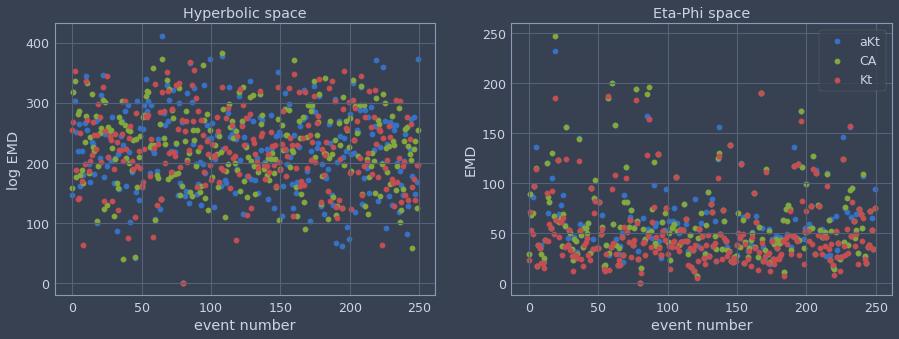

In [23]:
fig, ax = plt.subplots(1,2, figsize=(15,5))
ax = ax.flatten()
title = ['Hyperbolic space', 'Eta-Phi space']
subtitle = ['aKt','CA','Kt']
y_axis = ['log EMD', 'EMD']

for i in range(2):
    print(title[i])
    if i==0:
        record = np.transpose(hyp_record)
    else:
        record = np.transpose(euc_record)
    
    length = range(len(record[0]))
    for k in range(3):
        ax[i].scatter(length, record[k], label=subtitle[k])
        print(f'mean {subtitle[k]}: {np.mean(record[k]):.4f}')
        
    ax[i].set_xlabel('event number')
    ax[i].set_ylabel(y_axis[i])
    ax[i].set_title(title[i])

#ax[0].set_ylim(7.5, 12) 
#ax[1].set_ylim(7.5, 18)
plt.legend()
plt.show()

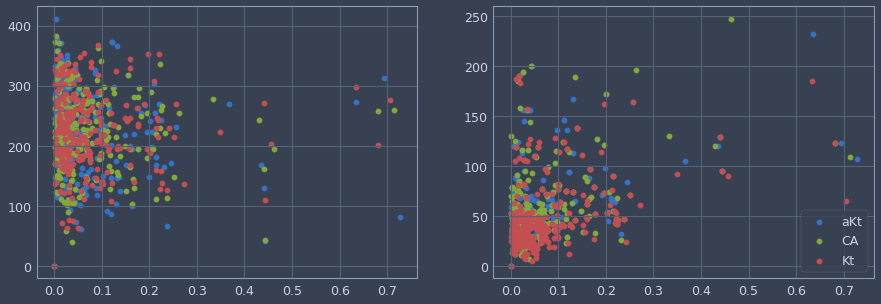

In [24]:
fig, ax = plt.subplots(1,2, figsize=(15,5))
ax = ax.flatten()
en = np.transpose(energy)
hyp = np.transpose(hyp_record)
euc = np.transpose(euc_record)
subtitle = ['aKt','CA','Kt']
color = ['orange','purple','green']
for i in range(3):
    ax[0].scatter(en[i],hyp[i],label=subtitle[i])
    ax[1].scatter(en[i],euc[i],label=subtitle[i])
plt.legend()

In [2]:
from random import randint

def gencoordinates(m, n):
    seen = set()
    x, y = randint(m, n), randint(m, n)
    while True:
        seen.add((x, y))
        yield (x, y)
        x, y = randint(m, n), randint(m, n)
        while (x, y) in seen:
            x, y = randint(m, n), randint(m, n)
            
def hyp_distance_matrix(n1,n2):
    matrix = np.zeros((len(n1),len(n2)))
    for i in range(len(n1)):
        for j in range(len(n2)):
            matrix[i][j] = sqdist(n1[i],n2[j])
    return matrix


def compute_emd(dataset, i0, i1):
    data1 = dataset[i0]
    data2 = dataset[i1]
    
    keys = [k for k in data1.keys()] 
    hyp_temp = []
    euc_temp = []
    energy = []
    for k in range(1, 6, 2):
        g1, h1 = data1[keys[k]], data1[keys[k+1]]
        g2, h2 = data2[keys[k]], data2[keys[k+1]]
        mask1 = g1.final
        mask2 = g2.final
        e1 = g1.pmu.data['e'][mask1]
        e2 = g2.pmu.data['e'][mask2]
        
        minimum = min(e1.sum(), e2.sum()) 
        energy.append(abs(e1.sum() - e2.sum()) / minimum)
        
        m = hyp_distance_matrix(h1[mask1], h2[mask2])
        m /= np.max(m)
        M = ot.partial.partial_wasserstein(e1, e2, m, minimum)
        
        cost = np.sum(M * m)
        hyp_temp.append(cost)

        m = g1.pmu[mask1].delta_R(g2.pmu[mask2])
        m /= np.max(m)
        M = ot.partial.partial_wasserstein(e1, e2, m, minimum)
        
        cost = np.sum(M * m)
        euc_temp.append(cost)

    return hyp_temp, euc_temp, energy
        
gen = gencoordinates(0, 99)

In [ ]:
dataset = OneSet('data/repeat_hadronise/signal-0.hdf5')
event = dataset[0]

keys = [k for k in event.keys()]
print(f'Number of events: {len(dataset)}')
print(f'Data keys: {keys}')

hyp_record = []
euc_record = []
energy = []
for i in tqdm(range(100)):
    pairs = next(gen)
    hyp_temp, euc_temp, energy_temp = compute_emd(dataset, pairs[0], pairs[1])
    hyp_record.append(hyp_temp)
    euc_record.append(euc_temp)
    energy.append(energy_temp)

Hyperbolic space
mean aKt: 37.7532
mean CA: 36.3146
mean Kt: 68.5197
Eta-Phi space
mean aKt: 11.1194
mean CA: 10.6661
mean Kt: 9.8335


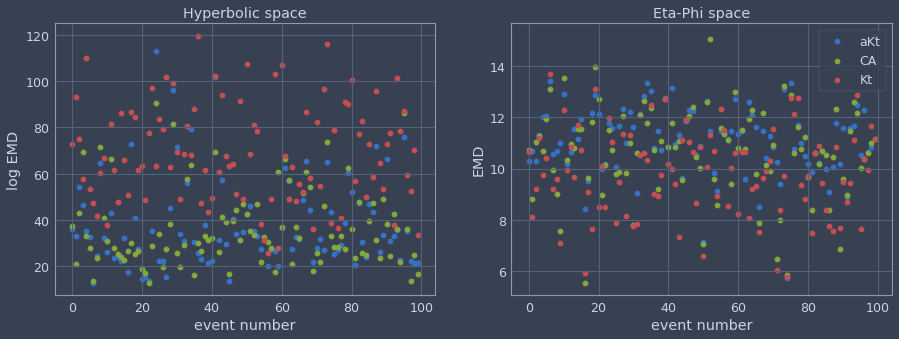

In [142]:
fig, ax = plt.subplots(1,2, figsize=(15,5))
ax = ax.flatten()
title = ['Hyperbolic space', 'Eta-Phi space']
subtitle = ['aKt','CA','Kt']
y_axis = ['log EMD', 'EMD']

for i in range(2):
    print(title[i])
    if i==0:
        record = np.transpose(hyp_record)
        #plt.ylim(0,50000)
    else:
        record = np.transpose(euc_record)
    
    length = range(len(record[0]))
    for k in range(3):
        ax[i].scatter(length, record[k], label=subtitle[k])
        print(f'mean {subtitle[k]}: {np.mean(record[k]):.4f}')
        
    ax[i].set_xlabel('event number')
    ax[i].set_ylabel(y_axis[i])
    ax[i].set_title(title[i])

plt.legend()
plt.show()

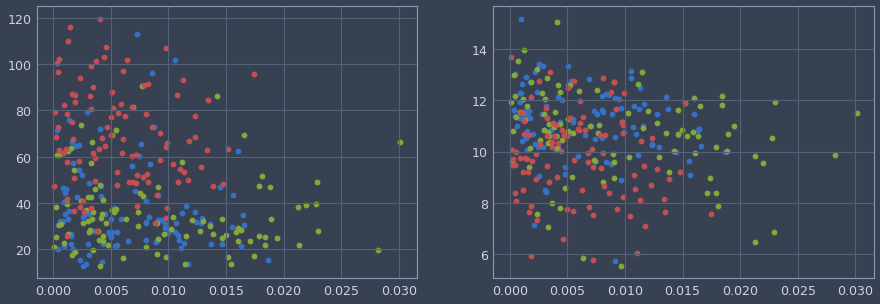

In [143]:
fig, ax = plt.subplots(1,2, figsize=(15,5))
ax = ax.flatten()
en = np.transpose(energy)
hyp = np.transpose(hyp_record)
euc = np.transpose(euc_record)
color = ['orange','purple','green']
for i in range(3):
    ax[0].scatter(en[i],hyp[i])
    ax[1].scatter(en[i],euc[i])

In [89]:
def compare_emd(dataset, i0, i1):
    data1 = dataset[i0]
    data2 = dataset[i1]
    
    keys = [k for k in data1.keys()] 
    M = []
    k=1
    g1, h1 = data1[keys[k]], data1[keys[k+1]]
    g2, h2 = data2[keys[k]], data2[keys[k+1]]
    mask1 = g1.final
    mask2 = g2.final
    e1 = g1.pmu.data['e'][mask1]
    e2 = g2.pmu.data['e'][mask2]

    minimum = min(e1.sum(), e2.sum()) 

    m = hyp_distance_matrix(h1[mask1], h2[mask2])
    m /= np.max(m)
    
    reg = 0.005
    reg_m_kl = 0.05
    reg_m_l2 = 5
    mass = minimum

    M.append(ot.partial.partial_wasserstein(e1, e2, m, mass))
    M.append(ot.unbalanced.sinkhorn_unbalanced(e1, e2, m, reg, reg_m_kl))
    M.append(ot.unbalanced.mm_unbalanced(e1, e2, m, reg_m_kl, div='kl'))
    M.append(ot.unbalanced.mm_unbalanced(e1, e2, m, reg_m_l2, div='l2'))
    return M, m

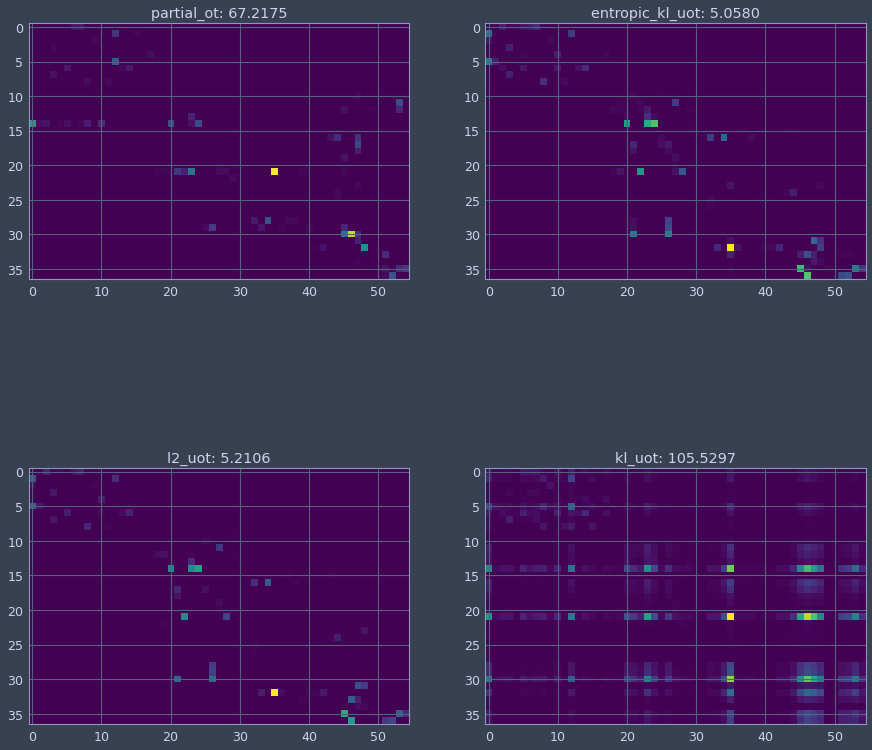

In [95]:
M, m = compare_emd(dataset, 0, 1)
fig, ax = plt.subplots(2,2,figsize=(15,15))
ax = ax.flatten()
transp = ['partial_ot', 'entropic_kl_uot', 'l2_uot', 'kl_uot']
for i in range(4):
    ax[i].imshow(M[i])
    ax[i].set_title(f'{transp[i]}: {np.sum(M[i] *m):.4f}')

## Data check

In [2]:
%run data_handler.py
dataset = ParticleDataset('data/compare_tree/train_bkg/')
event = dataset[0]

keys = [k for k in event.keys()]
print(f'Number of events: {len(dataset)}')
print(f'Data keys: {keys}')

Number of events: 16499
Data keys: ['MC_graph', 'aKt_graph', 'aKt_hyp', 'CA_graph', 'CA_hyp', 'Kt_graph', 'Kt_hyp']


In [3]:
from heparchy.read.hdf import HdfReader
def data_check():
    '''Check to make sure all data has CA mask
    '''
    from pathlib import Path

    folder_names = ['data/compare_tree/train_bkg/']
    corrupted = []
    for folder in folder_names:
        p = Path(folder).glob('**/*')
        files = [str(x) for x in p if x.is_file()]

        for f in tqdm(files):
            if f[-2:] == 'gz':
                continue
            try:
                with HdfReader(f) as hep_file:
                    try: proc = hep_file.read_process("background")
                    except KeyError: proc = hep_file.read_process("signal")
                    for event in proc:
                        try:
                            #mc = event.edges
                            mask = event.get_custom('aKt_mask')
                            mask = event.get_custom('CA_mask')
                            mask = event.get_custom('Kt_mask')
                        except KeyError:
                            corrupted.append(f)
                        
                            
            except KeyError: 
                print(f"File {f} produced CA error")
                raise

    print('Checks passed') 
    print(corrupted)
data_check()

100%|███████████████████████████████| 41/41 [00:21<00:00,  1.89it/s]

Checks passed
['data/compare_tree/train_bkg/gz_train-3.hdf5']
